# Overview

- Locations and depths of the shallowest parts of the Waal (MGD) are published daily by RWS to inform shipping companies
- Used to determine limits on the weight of cargo
- Published information is based on daily depth measurements carried out by a dedicated flee that scans previously identified likely regions

- In the advanced approach, we investgiated the usability of the crowd-sourced daily sounding data obtained by a fleet of commercial vessels, provided by covadem, which are available in near real time

# Approach

- A direct prediction of the MGD locations is not possible since they are 'aggregate entities'
- We will predict the depths along the whole river on a given day
- Can identify the MGDs as the smallest value in the predictions


# Data
- The new input data offer a high number of daily values in river depths
- However these cover only a subsection of individual locations
- Divide the river into a series of small regions and aggregate depth measurements available in each


## In detail

- River split into aggregation regions
- 100x50m in size, 3 across canal width
- ~Total of 2529 regions, covering around 85km of the river
- 1188 dates 

## Data used
1. Bi-weekly multibream scans
2. Daily crowd source depth measurements
3. Ship counts across the Waal
4. Data of river bed composition

In [1]:
import sys

import folium
import geopandas as gpd
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from filterpy.kalman import KalmanFilter
from fiona.crs import from_epsg
from shapely.geometry import Point
from sklearn.decomposition import DictionaryLearning, MiniBatchDictionaryLearning
from tqdm.notebook import tqdm
sys.path.append('/home/jovyan/river-levels/src/')

from data.data_utils import calculate_water_levels
from setup.database import db_con

db = db_con()

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
import pandas as pd
from model.utils import get_npArray
from model.features import Training

In [13]:
full_depths = get_npArray("61255f4616af8920b7ce5385")


In [14]:
distance = 4
lookback = 7
lookahead = 4
limit=None
data=full_depths

In [51]:
reg_gdf = pd.read_pickle('../data/processed/shipping_channel_100mx3_regions_with_metadata.p.gz', compression='gzip')
reg_gdf = GeoDataFrame(reg_gdf, crs="EPSG:28992", geometry=reg_gdf["geometry"])
reg_gdf['shipping_region'] = 'reg1'
reg_gdf.loc[reg_gdf['waal_km'] > 887, 'shipping_region'] = 'reg2'
reg_gdf.loc[reg_gdf['waal_km'] > 905, 'shipping_region'] = 'reg3'
reg_gdf.loc[reg_gdf['waal_km'] > 914, 'shipping_region'] = 'reg4'
reg_gdf.loc[reg_gdf['waal_km'] > 926, 'shipping_region'] = 'reg5'

In [52]:
reg_gdf

FID     waal_km                                           geometry  \
0        0  867.344640  POLYGON ((200019.075 431553.477, 199995.935 43...   
1        1  867.377582  POLYGON ((199997.398 431642.141, 199823.421 43...   
2        2  867.411435  POLYGON ((199975.721 431730.805, 199830.708 43...   
3        3  867.524400  POLYGON ((199816.134 431626.246, 199813.771 43...   
4        4  867.536241  POLYGON ((199823.421 431678.001, 199739.393 43...   
...    ...         ...                                                ...   
2524  2524  953.000000  POLYGON ((128269.526 425924.399, 128172.385 42...   
2525  2525  953.000000  POLYGON ((128259.925 425973.454, 128162.268 42...   
2526  2526  953.000000  POLYGON ((128182.502 425855.703, 128166.081 42...   
2527  2527  953.000000  POLYGON ((128172.385 425904.698, 128121.258 42...   
2528  2528  953.000000  POLYGON ((128162.268 425953.694, 128117.820 42...   

      curvature  no_dredging shipping_region  
0     -0.006011        False            reg1  
1     -0.005561        False            reg1  
2     -0.006904        False            reg1  
3     -0.006311        False            reg1  
4     -0.005787        False            reg1  
...         ...          ...             ...  
2524        NaN        False            reg5  
2525        NaN        False            reg5  
2526        NaN         True            reg5  
2527        NaN        False            reg5  
2528        NaN        False            reg5  

[2529 rows x 6 columns]

In [57]:
ship_df

date region  ship_counts
0     2012-01-01   reg5        100.0
1     2012-01-01   reg3        132.0
2     2012-01-01   reg2        123.0
3     2012-01-01   reg1        139.0
4     2012-01-01   reg4        104.0
...          ...    ...          ...
14235 2019-10-20   reg4        216.0
14236 2019-10-20   reg3        255.0
14237 2019-10-20   reg2        261.0
14238 2019-10-20   reg5        214.0
14239 2019-10-20   reg1        252.0

[14240 rows x 3 columns]

In [67]:
metadata = output_metadata

In [64]:
ship_df = pd.DataFrame(db['kk_ship_counts'].find({}, {"_id":0}))
ship_counts = pd.DataFrame(output_metadata).copy()

# merge to match region triplet with ship counts for each day
ship_counts['example_region'] = ship_counts['region_triplet'] * 3
ship_counts = pd.merge(
    ship_counts,
    reg_gdf[['FID', 'shipping_region']],
    left_on='example_region',
    right_on='FID'
)
ship_counts.drop(['example_region', 'FID'], axis=1, inplace=True)

ship_counts = pd.merge(
    ship_counts,
    ship_df,
    left_on=['datetime', 'shipping_region'],
    right_on=['date', 'region']
)
ship_counts.drop(['shipping_region', 'date', 'region'], axis=1, inplace=True)

# pivot and reindex to complete date range
ship_counts = pd.pivot_table(ship_counts, index='datetime', columns='region_triplet', values='ship_counts')
full_index = pd.date_range(start=ship_counts.index.min(), end=ship_counts.index.max())
ship_counts = ship_counts.reindex(full_index)

In [65]:
ship_counts

region_triplet    4      5      6      7      8      9      10     11     12   \
2017-01-08      277.0  277.0  277.0  277.0  277.0  277.0  277.0  277.0  277.0   
2017-01-09      317.0  317.0  317.0  317.0  317.0  317.0  317.0  317.0  317.0   
2017-01-10      402.0  402.0  402.0  402.0  402.0  402.0  402.0  402.0  402.0   
2017-01-11      398.0  398.0  398.0  398.0  398.0  398.0  398.0  398.0  398.0   
2017-01-12      424.0  424.0  424.0  424.0  424.0  424.0  424.0  424.0  424.0   
...               ...    ...    ...    ...    ...    ...    ...    ...    ...   
2019-10-16      333.0  333.0  333.0  333.0  333.0  333.0  333.0  333.0  333.0   
2019-10-17      305.0  305.0  305.0  305.0  305.0  305.0  305.0  305.0  305.0   
2019-10-18      309.0  309.0  309.0  309.0  309.0  309.0  309.0  309.0  309.0   
2019-10-19      280.0  280.0  280.0  280.0  280.0  280.0  280.0  280.0  280.0   
2019-10-20      252.0  252.0  252.0  252.0  252.0  252.0  252.0  252.0  252.0   

region_triplet    13     14     15     16     17     18     19     20     21   \
2017-01-08      277.0  277.0  277.0  277.0  277.0  277.0  277.0  277.0  277.0   
2017-01-09      317.0  317.0  317.0  317.0  317.0  317.0  317.0  317.0  317.0   
2017-01-10      402.0  402.0  402.0  402.0  402.0  402.0  402.0  402.0  402.0   
2017-01-11      398.0  398.0  398.0  398.0  398.0  398.0  398.0  398.0  398.0   
2017-01-12      424.0  424.0  424.0  424.0  424.0  424.0  424.0  424.0  424.0   
...               ...    ...    ...    ...    ...    ...    ...    ...    ...   
2019-10-16      333.0  333.0  333.0  333.0  333.0  333.0  333.0  333.0  333.0   
2019-10-17      305.0  305.0  305.0  305.0  305.0  305.0  305.0  305.0  305.0   
2019-10-18      309.0  309.0  309.0  309.0  309.0  309.0  309.0  309.0  309.0   
2019-10-19      280.0  280.0  280.0  280.0  280.0  280.0  280.0  280.0  280.0   
2019-10-20      252.0  252.0  252.0  252.0  252.0  252.0  252.0  252.0  252.0   

region_triplet    22     23     24     25     26     27     28     29     30   \
2017-01-08      277.0  277.0  277.0  277.0  277.0  277.0  277.0  277.0  277.0   
2017-01-09      317.0  317.0  317.0  317.0  317.0  317.0  317.0  317.0  317.0   
2017-01-10      402.0  402.0  402.0  402.0  402.0  402.0  402.0  402.0  402.0   
2017-01-11      398.0  398.0  398.0  398.0  398.0  398.0  398.0  398.0  398.0   
2017-01-12      424.0  424.0  424.0  424.0  424.0  424.0  424.0  424.0  424.0   
...               ...    ...    ...    ...    ...    ...    ...    ...    ...   
2019-10-16      333.0  333.0  333.0  333.0  333.0  333.0  333.0  333.0  333.0   
2019-10-17      305.0  305.0  305.0  305.0  305.0  305.0  305.0  305.0  305.0   
2019-10-18      309.0  309.0  309.0  309.0  309.0  309.0  309.0  309.0  309.0   
2019-10-19      280.0  280.0  280.0  280.0  280.0  280.0  280.0  280.0  280.0   
2019-10-20      252.0  252.0  252.0  252.0  252.0  252.0  252.0  252.0  252.0   

region_triplet    31     32     33     34     35     36     37     38     39   \
2017-01-08      277.0  277.0  277.0  277.0  277.0  277.0  277.0  277.0  277.0   
2017-01-09      317.0  317.0  317.0  317.0  317.0  317.0  317.0  317.0  317.0   
2017-01-10      402.0  402.0  402.0  402.0  402.0  402.0  402.0  402.0  402.0   
2017-01-11      398.0  398.0  398.0  398.0  398.0  398.0  398.0  398.0  398.0   
2017-01-12      424.0  424.0  424.0  424.0  424.0  424.0  424.0  424.0  424.0   
...               ...    ...    ...    ...    ...    ...    ...    ...    ...   
2019-10-16      333.0  333.0  333.0  333.0  333.0  333.0  333.0  333.0  333.0   
2019-10-17      305.0  305.0  305.0  305.0  305.0  305.0  305.0  305.0  305.0   
2019-10-18      309.0  309.0  309.0  309.0  309.0  309.0  309.0  309.0  309.0   
2019-10-19      280.0  280.0  280.0  280.0  280.0  280.0  280.0  280.0  280.0   
2019-10-20      252.0  252.0  252.0  252.0  252.0  252.0  252.0  252.0  252.0   

region_triplet    40     41     42     43     44     45     46     47     48   \
2017-01-08      277.0  277.

In [70]:
np.empty((1, lookback, 1)).shape

(1, 7, 1)

In [71]:
lookback = 42
shipping_data = []

for i, meta in tqdm(enumerate(metadata)):  # 747695 entries
    sys.stdout.write(f'\rDoing row {i+1}/{len(metadata)}')
    if meta['datetime'] >= pd.Timestamp('2019-10-13'):
        past_sh = np.empty((1, lookback, 1))
        past_sh[:] = np.nan
        shipping_data.append(past_sh)
        continue

    try:
        row = ship_counts.index.get_loc(meta['datetime'])
        col = meta['region_triplet']
        past_sh = ship_counts.iloc[row - lookback + 1 : row + 1][col].values.reshape(1,-1,1)
    except:
        past_sh = np.empty((1,lookback,1))
        past_sh[:] = np.nan

    if past_sh.shape != (1,lookback,1):
        past_sh = np.empty((1,lookback,1))
        past_sh[:] = np.nan

    shipping_data.append(past_sh)

shipping_data = np.concatenate(shipping_data, axis=0)
# sum across axis 1 and 2
ship_filter = np.isnan(shipping_data).sum(axis=(1,2)) == 0

0it [00:00, ?it/s]

Doing row 747695/747695

In [75]:
metadata[0]

{'datetime': Timestamp('2017-01-08 00:00:00', freq='D'), 'region_triplet': 4}

In [76]:
ship_counts.index.get_loc(metadata[0]['datetime'])

0

In [80]:
ship_counts.index.get_loc(metadata[1]['datetime'])

0

In [84]:
len(metadata)

747695

In [ ]:
training = Training()
feats, targs, metadata = training.create_training_examples(data=full_depths, dates=all_dates, lookback=42)
reg_gdf = Training.create_reg_gdf()
training.create_ship_filter(metadata, reg_gdf)

# 1. Biweekly multibeam data

- The biweekly multibeam measurements used in the first MGD project are delivered with a significant delay
- Multiple checks and evaluations are performed to make sure they are correct
- 7 years of data

In [2]:
mgd_df = pd.read_pickle('/home/jovyan/river-levels/data/processed/big_biweekly_processed_shipping_canal.p.gz')
mgd_df['datetime'] = pd.to_datetime(mgd_df['datetime'], format="%Y-%M-%D %H:%M:%S")
mgd_df = mgd_df.sort_values("datetime").reset_index()

# 2. Covadem data

In [6]:
covadem_df = pd.DataFrame(db['kk_covadem_100x50m_kalman_quantiles_and_numbers'].find({}, {"_id":0}))
covadem_df['FID'] = covadem_df['FID'].astype(int)

## K-SVD

- In order to increase the coverage and enable more data to be used for training, K-SVD was used (k-mean singular value decomposition)
- It is a trainable dictionary learning algorithm commonly used for denoising image data
- It is applied in small patches across the whole image

- The measurements were filled in in patches of 3x3 regions
- We required at least three daily measurements to be present in any given patch for KSVD to be applicable
- That means that the data is filled in with the exception of larger continuous areas of the river with missing measurements

- In the original dataset, 21% of the regions have missing measurements
- After applying KSVD, this decreases to 3.5%

In [9]:
# not sure what this is
depths = cov_df['percentile_00'].values.reshape(3, 3, -1, order='F')
depths_to_fill = np.transpose(depths.reshape(-1, depths.shape[2]))

nan_mask = np.isnan(depths_to_fill)
fin_mask = ~nan_mask
depths_to_fill[nan_mask] = np.nanmedian(depths_to_fill)
filled_depths = ksvd.transform(depths_to_fill)
filled_depths = np.dot(filled_depths, ksvd.components_)
depths_to_fill[nan_mask] = filled_depths[nan_mask]
depths_to_fill[~(fin_mask.sum(axis=1) >= min_available_depths), :] = np.nan
print(np.isnan(depths_to_fill).sum() / depths_to_fill.size)

0.03202846975088968


In [10]:
depths_to_fill = np.transpose(depths_to_fill.reshape(-1,3,3, order='F').reshape(-1,3))
depths_to_fill = np.expand_dims(depths_to_fill, axis=2)  # (3, 843, 1)

In [11]:
depths_to_fill.shape

(3, 843, 1)

In [17]:
full_depths.shape  # 3x843 region blocks, 1080 days

(3, 843, 1080)

In [18]:
np.isnan(full_depths).sum() / full_depths.size

0.034380812208016635

Filled in data distributions:
0.01    1.880000
0.05    2.710000
0.25    3.930000
0.50    4.740000
0.75    5.520000
0.95    7.260000
0.99    9.077585
dtype: float64

Original data distributions:
0.01    1.81
0.05    2.62
0.25    3.84
0.50    4.68
0.75    5.50
0.95    7.13
0.99    9.03
Name: percentile_00, dtype: float64


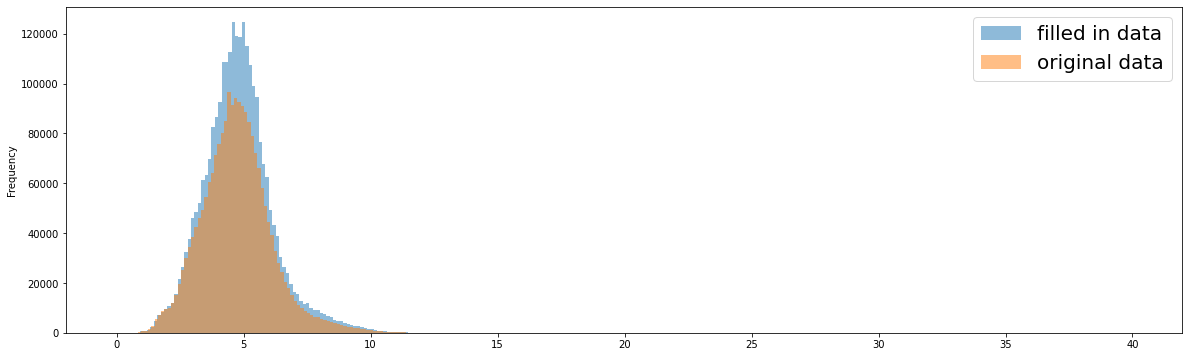

In [19]:
fig,ax = plt.subplots(figsize=(20,6))

ser = pd.Series(full_depths.flatten())
ser.plot.hist(ax=ax, bins=300, label='filled in data', alpha=0.5, density=False)
covadem_df['percentile_00'].plot.hist(ax=ax, bins=300, label='original data', alpha=0.5, density=False)
ax.legend(fontsize=20)
fig.show()

print('Filled in data distributions:')
print(ser.quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))
print("")
print('Original data distributions:')
print(covadem_df['percentile_00'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

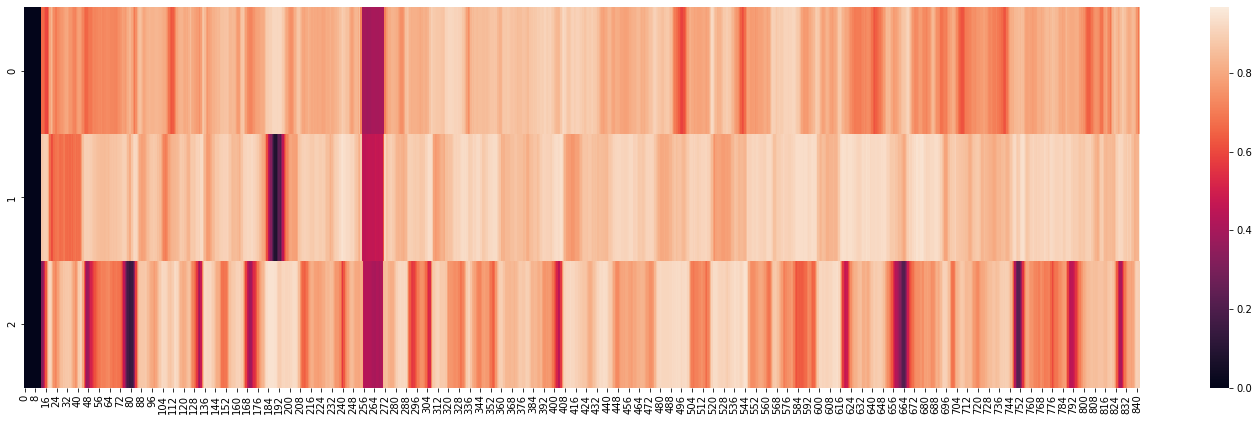

In [20]:
fig, ax = plt.subplots(figsize=(25,7))
sns.heatmap(original_data.sum(axis=2)[:,::-1] / original_data.shape[2], ax=ax)
fig.show()

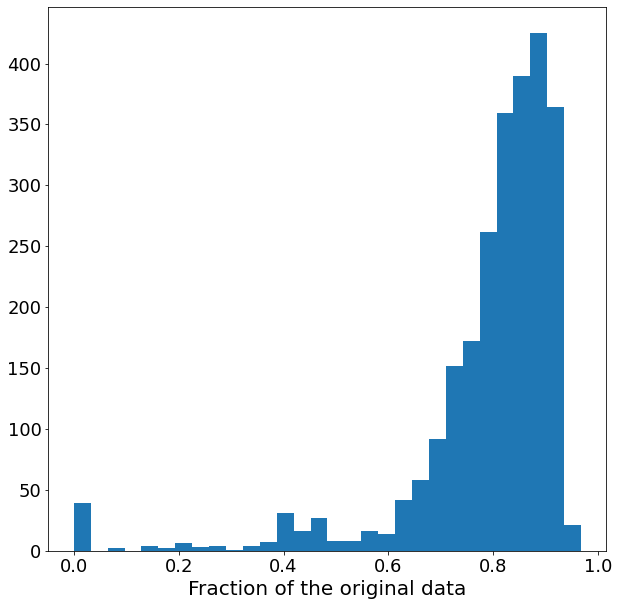

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
pd.Series((original_data.sum(axis=2) / original_data.shape[2]).flatten()).plot.hist(ax=ax, bins=30)
ax.set_ylabel('')
ax.set_xlabel('Fraction of the original data', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
fig.show()

In [26]:
# probably means location 435 had most filled in?
np.argmax(original_data.sum(axis=2), axis=1)

array([435,   0, 655])

489285concatenating
done concatenating


In [84]:
feats.shape

(489285, 1, 3, 9, 42)

In [85]:
targs.shape

(489285, 12)

In [86]:
len(metadata)

489285

In [87]:
pd.DataFrame(metadata).nunique()

datetime          952
region_triplet    823
dtype: int64

In [88]:
filled_df = []

for i in tqdm(range(len(all_dates))):
    tmp_df = pd.DataFrame(full_depths[:,:,i].flatten(order='F'), columns=['percentile_00'])
    tmp_df['datetime'] = all_dates[i]
    tmp_df['FID'] = tmp_df.index
    
    filled_df.append(tmp_df)
    
filled_df = pd.concat(filled_df)

print(filled_df.shape)
filled_df

  0%|          | 0/1080 [00:00<?, ?it/s]

(2731320, 3)


percentile_00   datetime   FID
0          3.947000 2017-01-01     0
1          3.750000 2017-01-01     1
2          3.240000 2017-01-01     2
3          3.819332 2017-01-01     3
4          3.553046 2017-01-01     4
...             ...        ...   ...
2524            NaN 2019-12-16  2524
2525            NaN 2019-12-16  2525
2526            NaN 2019-12-16  2526
2527            NaN 2019-12-16  2527
2528            NaN 2019-12-16  2528

[2731320 rows x 3 columns]

In [91]:
ksvd_df = pd.merge(filled_df, covadem_df, on=['datetime', 'FID'], how='left', suffixes=('_ksvd', '_orig'))

print(ksvd_df.shape)
ksvd_df

(2731320, 13)


percentile_00_ksvd   datetime   FID  percentile_00_orig  \
0                  3.947000 2017-01-01     0                 NaN   
1                  3.750000 2017-01-01     1                3.75   
2                  3.240000 2017-01-01     2                3.24   
3                  3.819332 2017-01-01     3                 NaN   
4                  3.553046 2017-01-01     4                 NaN   
...                     ...        ...   ...                 ...   
2731315                 NaN 2019-12-16  2524                 NaN   
2731316                 NaN 2019-12-16  2525                 NaN   
2731317                 NaN 2019-12-16  2526                 NaN   
2731318                 NaN 2019-12-16  2527                 NaN   
2731319                 NaN 2019-12-16  2528                 NaN   

         percentile_01  percentile_05  percentile_25  percentile_50  \
0                  NaN            NaN            NaN            NaN   
1               3.7542         3.7735          3.935           4.20   
2               3.2832         3.4560          3.830           3.93   
3                  NaN            NaN            NaN            NaN   
4                  NaN            NaN            NaN            NaN   
...                ...            ...            ...            ...   
2731315            NaN            NaN            NaN            NaN   
2731316            NaN            NaN            NaN            NaN   
2731317            NaN            NaN            NaN            NaN   
2731318            NaN            NaN            NaN            NaN   
2731319            NaN            NaN            NaN            NaN   

         percentile_75  percentile_95  percentile_99  percentile_100  \
0                  NaN            NaN            NaN             NaN   
1               4.2475          4.357         4.3837            4.39   
2               4.3300          4.432         4.4544            4.46   
3                  NaN            NaN            NaN             NaN   
4                  NaN            NaN            NaN             NaN   
...                ...            ...            ...             ...   
2731315            NaN            NaN            NaN             NaN   
2731316            NaN            NaN            NaN             NaN   
2731317            NaN            NaN            NaN             NaN   
2731318            NaN            NaN            NaN             NaN   
2731319            NaN            NaN            NaN             NaN   

         n_measurements  
0                   NaN  
1                  22.0  
2                   9.0  
3                   NaN  
4                   NaN  
...                 ...  
2731315             NaN  
2731316             NaN  
2731317             NaN  
2731318             NaN  
2731319             NaN  

[2731320 rows x 13 columns]

In [92]:
ksvd_df = ksvd_df[ksvd_df['percentile_00_orig'].isnull()]
ksvd_df.drop('percentile_00_orig', axis=1, inplace=True)

print(ksvd_df.isnull().sum())
print("")
ksvd_df.dropna(inplace=True)
print("")
print(ksvd_df.isnull().sum())
print("")
print(ksvd_df.shape)
ksvd_df

percentile_00_ksvd     91346
datetime                   0
FID                        0
percentile_01         568981
percentile_05         568981
percentile_25         568981
percentile_50         568981
percentile_75         568981
percentile_95         568981
percentile_99         568981
percentile_100        568981
n_measurements        568981
dtype: int64


percentile_00_ksvd    0.0
datetime              0.0
FID                   0.0
percentile_01         0.0
percentile_05         0.0
percentile_25         0.0
percentile_50         0.0
percentile_75         0.0
percentile_95         0.0
percentile_99         0.0
percentile_100        0.0
n_measurements        0.0
dtype: float64

(0, 12)


/home/jovyan/conda-envs/river/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/jovyan/conda-envs/river/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Empty DataFrame
Columns: [percentile_00_ksvd, datetime, FID, percentile_01, percentile_05, percentile_25, percentile_50, percentile_75, percentile_95, percentile_99, percentile_100, n_measurements]
Index: []

# 2.a Add other data sets

In [93]:
level_df = pd.read_csv('~/mgd2_rws_datalab/data/raw/20191017_018.csv', sep=';', encoding='latin-1', decimal=',')

In [94]:
level_df

MONSTER_IDENTIFICATIE               MEETPUNT_IDENTIFICATIE  \
0                          NaN  Bovenrijn km. 857.900 Rechter oever   
1                          NaN  Bovenrijn km. 857.900 Rechter oever   
2                          NaN  Bovenrijn km. 857.900 Rechter oever   
3                          NaN  Bovenrijn km. 857.900 Rechter oever   
4                          NaN  Bovenrijn km. 857.900 Rechter oever   
...                        ...                                  ...   
3770348                    NaN                           Zaltbommel   
3770349                    NaN                           Zaltbommel   
3770350                    NaN                           Zaltbommel   
3770351                    NaN                           Zaltbommel   
3770352                    NaN                           Zaltbommel   

         TYPERING_OMSCHRIJVING  TYPERING_CODE GROOTHEID_OMSCHRIJVING  \
0                          NaN            NaN            Waterhoogte   
1                          NaN            NaN            Waterhoogte   
2                          NaN            NaN            Waterhoogte   
3                          NaN            NaN            Waterhoogte   
4                          NaN            NaN            Waterhoogte   
...                        ...            ...                    ...   
3770348                    NaN            NaN            Waterhoogte   
3770349                    NaN            NaN            Waterhoogte   
3770350                    NaN            NaN            Waterhoogte   
3770351                    NaN            NaN            Waterhoogte   
3770352                    NaN            NaN            Waterhoogte   

        GROOTHEID_ CODE  PARAMETER_OMSCHRIJVING  PARAMETER_ CODE EENHEID_CODE  \
0                WATHTE                     NaN              NaN           cm   
1                WATHTE                     NaN              NaN           cm   
2                WATHTE                     NaN              NaN           cm   
3                WATHTE                     NaN              NaN           cm   
4                WATHTE                     NaN              NaN           cm   
...                 ...                     ...              ...          ...   
3770348          WATHTE                     NaN              NaN           cm   
3770349          WATHTE                     NaN              NaN           cm   
3770350          WATHTE                     NaN              NaN           cm   
3770351          WATHTE                     NaN              NaN           cm   
3770352          WATHTE                     NaN              NaN           cm   

              HOEDANIGHEID_OMSCHRIJVING HOEDANIGHEID_CODE  \
0        t.o.v. Normaal Amsterdams Peil               NAP   
1        t.o.v. Normaal Amsterdams Peil               NAP   
2        t.o.v. Normaal Amsterdams Peil               NAP   
3        t.o.v. Normaal Amsterdams Peil               NAP   
4        t.o.v. Normaal Amsterdams Peil               NAP   
...                                 ...               ...   
3770348  t.o.v. Normaal Amsterdams Peil               NAP   
3770349  t.o.v. Normaal Amsterdams Peil               NAP   
3770350  t.o.v. Normaal Amsterdams Peil               NAP   
3770351  t.o.v. Normaal Amsterdams Peil               NAP   
3770352  t.o.v. Normaal Amsterdams Peil               NAP   

        COMPARTIMENT_OMSCHRIJVING COMPARTIMENT_CODE  \
0                Oppervlaktewater                OW   
1                Oppervlaktewater                OW   
2                Oppervlaktewater                OW   
3                Oppervlaktewater                OW   
4                Oppervlaktewater                OW   
...                           ...               ...   
3770348          Oppervlaktewater                OW   
3770349          Oppervlaktewater                OW   
3770350          Oppervlaktewater                OW   
3770351          Oppervlaktewater  

In [95]:
to_drop = []
for col in tqdm(level_df.columns):
    if level_df[col].nunique() < 2:
        to_drop.append(col)
        
print('Dropping {} columns: {}'.format(len(to_drop), to_drop))
level_df.drop(to_drop, axis=1, inplace=True)
print("")

print(level_df.shape)
print("")
level_df = level_df[level_df['NUMERIEKEWAARDE'] < 9e8].copy()
print(level_df.shape)
print("")

level_df['timestamp'] = pd.to_datetime(level_df.apply(lambda x: '{} {}'.format(x['WAARNEMINGDATUM'], x['WAARNEMINGTIJD']), axis=1), format='%d-%m-%Y %H:%M:%S')
pivoted_df = pd.pivot_table(level_df, index='timestamp', columns='MEETPUNT_IDENTIFICATIE', values='NUMERIEKEWAARDE')

target_cols = 100*pivoted_df.isnull().sum()/len(pivoted_df) < 10
target_cols = list(target_cols[target_cols].index)

print(pivoted_df.shape)
print("")
pivoted_df = pivoted_df.loc['2017-01-01':, target_cols]
print(pivoted_df.shape)
print("")

del level_df
gc.collect()

  0%|          | 0/41 [00:00<?, ?it/s]

Dropping 26 columns: ['MONSTER_IDENTIFICATIE', 'TYPERING_OMSCHRIJVING', 'TYPERING_CODE', 'GROOTHEID_OMSCHRIJVING', 'GROOTHEID_ CODE', 'PARAMETER_OMSCHRIJVING', 'PARAMETER_ CODE', 'EENHEID_CODE', 'HOEDANIGHEID_OMSCHRIJVING', 'HOEDANIGHEID_CODE', 'COMPARTIMENT_OMSCHRIJVING', 'COMPARTIMENT_CODE', 'WAARDEBEWERKINGSMETHODE_OMSCHRIJVING', 'WAARDEBEWERKINGSMETHODE_CODE', 'BEMONSTERINGSSOORT_OMSCHRIJVING', 'BEMONSTERINGSSOORT_CODE', 'LIMIETSYMBOOL', 'ALFANUMERIEKEWAARDE', 'BEMONSTERINGSAPPARAAT_OMSCHRIJVING', 'BEMONSTERINGSAPPARAAT_CODE', 'PLAATSBEPALINGSAPPARAAT_OMSCHRIJVING', 'PLAATSBEPALINGSAPPARAAT_CODE', 'EPSG', 'ORGAAN_OMSCHRIJVING', 'ORGAAN_CODE', 'TAXON_NAME']

(3770353, 15)

(3762514, 15)

(462448, 37)

(146806, 6)



0

In [96]:
pivoted_df.head()

MEETPUNT_IDENTIFICATIE  Lobith  Nijmegen haven  Pannerdense Kop  Tiel Waal  \
timestamp                                                                    
2017-01-01 00:00:00      726.0           506.0            692.0      249.0   
2017-01-01 00:10:00      726.0           506.0            693.0      249.0   
2017-01-01 00:20:00      725.0           505.0            693.0      249.0   
2017-01-01 00:30:00      726.0           506.0            693.0      249.0   
2017-01-01 00:40:00      726.0           508.0            693.0      250.0   

MEETPUNT_IDENTIFICATIE  Vuren  Zaltbommel  
timestamp                                  
2017-01-01 00:00:00      44.0        89.0  
2017-01-01 00:10:00      44.0        88.0  
2017-01-01 00:20:00      44.0        88.0  
2017-01-01 00:30:00      44.0        87.0  
2017-01-01 00:40:00      44.0        87.0

In [97]:
bet_df = pd.read_excel('betrekkingslijnen.xlsx', sheet_name='Bovenrijn-Waal', skiprows=4)
bet_df.dropna(how='all', inplace=True)
bet_df.rename(columns={'ws': 'ws.0'}, inplace=True)

print(bet_df.shape)
bet_df.head()

(116, 116)


peilschaal op LMW-punt  km-raai  ws.0  ws.1  ws.2  ws.3  ws.4  ws.5  ws.6  \
1                    NaN    854.0  7.93  7.99  8.06  8.13  8.21  8.29  8.39   
2                    NaN    855.0  7.71  7.78  7.85  7.93  8.01  8.10  8.19   
3                    NaN    856.0  7.43  7.51  7.58  7.67  7.75  7.84  7.93   
4                    NaN    857.0  7.21  7.29  7.37  7.46  7.55  7.64  7.76   
5                    NaN    858.0  7.04  7.13  7.22  7.31  7.40  7.49  7.62   

   ws.7  ws.8  ws.9  ws.10  ws.11  ws.12  ws.13  ws.14  ws.15  ws.16  ws.17  \
1  8.48  8.57  8.66   8.76   8.85   8.94   9.04   9.13   9.22   9.31   9.40   
2  8.28  8.37  8.47   8.56   8.66   8.75   8.85   8.94   9.03   9.13   9.21   
3  8.03  8.12  8.22   8.31   8.41   8.50   8.60   8.69   8.79   8.88   8.99   
4  7.86  7.95  8.05   8.14   8.24   8.34   8.43   8.53   8.63   8.72   8.84   
5  7.71  7.81  7.91   8.01   8.10   8.20   8.30   8.39   8.49   8.59   8.71   

   ws.18  ws.19  ws.20  ws.21  ws.22  ws.23  ws.24  ws.25  ws.26  ws.27  \
1   9.49   9.58   9.67   9.77   9.86   9.97  10.07  10.18  10.30  10.43   
2   9.30   9.40   9.49   9.59   9.68   9.79   9.89  10.00  10.12  10.25   
3   9.08   9.18   9.27   9.37   9.47   9.58   9.68   9.79   9.90  10.03   
4   8.94   9.04   9.13   9.23   9.33   9.44   9.54   9.65   9.76   9.89   
5   8.81   8.91   9.00   9.10   9.20   9.31   9.41   9.52   9.63   9.75   

   ws.28  ws.29  ws.30  ws.31  ws.32  ws.33  ws.34  ws.35  ws.36  ws.37  \
1  10.57  10.66  10.76  10.86  10.95  11.05  11.15  11.24  11.34  11.44   
2  10.38  10.47  10.57  10.67  10.77  10.86  10.96  11.06  11.16  11.26   
3  10.16  10.26  10.35  10.45  10.55  10.65  10.75  10.87  10.97  11.07   
4  10.01  10.11  10.21  10.31  10.41  10.50  10.60  10.72  10.82  10.92   
5   9.87   9.97  10.07  10.17  10.27  10.36  10.46  10.58  10.68  10.78   

   ws.38  ws.39  ws.40  ws.41  ws.42  ws.43  ws.44  ws.45  ws.46  ws.47  \
1  11.54  11.63  11.73  11.83  11.92  12.02  12.12  12.22  12.31  12.41   
2  11.36  11.45  11.55  11.65  11.75  11.84  11.94  12.05  12.15  12.24   
3  11.17  11.26  11.36  11.46  11.56  11.65  11.75  11.88  11.98  12.07   
4  11.02  11.12  11.21  11.31  11.41  11.51  11.61  11.74  11.84  11.93   
5  10.88  10.98  11.08  11.18  11.28  11.37  11.47  11.59  11.69  11.79   

   ws.48  ws.49  ws.50  ws.51  ws.52  ws.53  ws.54  ws.55  ws.56  ws.57  \
1  12.51  12.60  12.70  12.80  12.90  13.00  13.09  13.19  13.29  13.39   
2  12.34  12.44  12.53  12.63  12.73  12.83  12.93  13.03  13.12  13.22   
3  12.17  12.27  12.37  12.47  12.57  12.67  12.77  12.87  12.97  13.06   
4  12.03  12.13  12.23  12.33  12.43  12.53  12.63  12.73  12.83  12.93   
5  11.89  11.99  12.09  12.18  12.29  12.38  12.48  12.58  12.68  12.78   

   ws.58  ws.59  ws.60  ws.61  ws.62  ws.63  ws.64  ws.65  ws.66  ws.67  \
1  13.49  13.58  13.68  13.78  13.88  14.01  14.11  14.21  14.31  14.41   
2  13.32  13.42  13.52  13.62  13.72  13.83  13.93  14.03  14.13  14.23   
3  13.16  13.26  13.36  13.46  13.56  13.69  13.79  13.89  13.99  14.09   
4  13.03  13.12  13.22  13.32  13.42  13.55  13.65  13.75  13.85  13.95   
5  12.88  12.98  13.08  13.18  13.28  13.41  13.51  13.61  13.71  13.81   

   ws.68  ws.69  ws.70  ws.71  ws.72  ws.73  ws.74  ws.75  ws.76  ws.77  \
1  14.51  14.62  14.72  14.82  14.93  15.03  15.14  15.24  15.35  15.45   
2  14.33  14.44  14.54  14.64  14.74  14.85  14.95  15.06  15.16  15.29   
3  14.19  14.29  14.39  14.50  14.60  14.70  14.81  14.91  15.02  15.17   
4  14.05  14.15  14.26  14.36  14.46  14.56  14.67  14.77  14.87  15.04   
5  13.91  14.01  14.11  14.21  14.31  14.42  14.52  14.62  14.72  14.87   

   ws.78  ws.79  ws.80  ws.81  ws.82  ws.83  ws.84  ws.85  ws.86  ws.87  \
1  15.56  15.67  15.78  15.88  16.00  16.11  16.22  16.33  16.44  16.56   
2  15.40  15.51  15.61  15.72  15.83  15.94  16.05  16.16  16.27  16.39   
3  15.27  15.38  15.49  15.59  15.70  15.81  15.92  16.03  16.14  16.25   
4  15.14  15.25  15.36  15.46  15.57  15.68  1

In [48]:
water_levels = []
dates = []

region_locs = reg_gdf['waal_km'].unique()
for i, day_date in tqdm(enumerate(all_dates)):
    sys.stdout.write(f'\rDoing day {day_date} ({i+1}/{len(all_dates)})')
    # create the water levels
    try:
        meas_df = pd.DataFrame(pivoted_df.loc[pd.Timestamp(day_date).replace(hour=8)]) # take the water level at 8
    except KeyError:
        continue

    meas_df.columns = ['mNAP']
    meas_df['mNAP'] /= 100
    meas_df.index = meas_df.index.map(lambda x: x.lower())
    meas_df.dropna(inplace=True)

    try:
        water_level_df = calculate_water_levels(measurement_df=meas_df,
                                                betrekking_df=bet_df)
    except:
        continue
    
    dates.append(day_date)
    full_index = list(region_locs) + list(water_level_df.index)
    water_level_df = water_level_df.reindex(full_index)
    water_level_df.sort_index(inplace=True)
    water_level_df.interpolate(method='linear', inplace=True)
    # fill in the water level for each date
    tmp_gdf = reg_gdf.copy()
    tmp_gdf['water_level'] = np.nan    
    tmp_gdf['water_level'] = tmp_gdf['waal_km'].map(lambda x: water_level_df.loc[x].values[0])
    
    tmp_gdf.dropna(inplace=True)
    water_levels.append(tmp_gdf.set_index('FID')['water_level'].to_dict())

0it [00:00, ?it/s]

Doing day 2019-12-16 00:00:00 (1080/1080)

In [49]:
interpolated_water = pd.DataFrame(water_levels, index = dates)

In [50]:
interpolated_water

0         1         2         3         4         5     \
2017-01-01  6.906806  6.903612  6.900417  6.897223  6.894029  6.890835   
2017-01-02  6.856823  6.853646  6.850469  6.847292  6.844115  6.840937   
2017-01-03  6.846806  6.843612  6.840417  6.837223  6.834029  6.830835   
2017-01-04  6.856857  6.853714  6.850571  6.847428  6.844285  6.841142   
2017-01-05  6.856823  6.853646  6.850469  6.847292  6.844115  6.840937   
...              ...       ...       ...       ...       ...       ...   
2019-10-13  8.576852  8.573469  8.570085  8.566702  8.563318  8.559934   
2019-10-14  8.761186  8.758023  8.754860  8.751697  8.748533  8.745370   
2019-10-15  8.736594  8.733281  8.729967  8.726654  8.723341  8.720028   
2019-10-16  8.526243  8.523229  8.520216  8.517202  8.514188  8.511174   
2019-10-17  8.388571  8.385314  8.382057  8.378800  8.375543  8.372286   

                6         7         8         9         10        11    \
2017-01-01  6.887641  6.884447  6.881252  6.878058  6.874864  6.871670   
2017-01-02  6.837760  6.834583  6.831406  6.828229  6.825052  6.821875   
2017-01-03  6.827641  6.824447  6.821252  6.818058  6.814864  6.811670   
2017-01-04  6.837999  6.834857  6.831714  6.828571  6.825428  6.822285   
2017-01-05  6.837760  6.834583  6.831406  6.828229  6.825052  6.821875   
...              ...       ...       ...       ...       ...       ...   
2019-10-13  8.556551  8.553167  8.549783  8.546400  8.543016  8.539632   
2019-10-14  8.742207  8.739043  8.735880  8.732717  8.729554  8.726390   
2019-10-15  8.716715  8.713402  8.710088  8.706775  8.703462  8.700149   
2019-10-16  8.508160  8.505146  8.502132  8.499118  8.496104  8.493091   
2019-10-17  8.369029  8.365772  8.362515  8.359258  8.356001  8.352744   

                12        13        14        15        16        17    \
2017-01-01  6.862087  6.865282  6.868476  6.858893  6.855699  6.852505   
2017-01-02  6.812344  6.815521  6.818698  6.809166  6.805989  6.802812   
2017-01-03  6.802087  6.805282  6.808476  6.798893  6.795699  6.792505   
2017-01-04  6.812856  6.815999  6.819142  6.809713  6.806570  6.803427   
2017-01-05  6.812344  6.815521  6.818698  6.809166  6.805989  6.802812   
...              ...       ...       ...       ...       ...       ...   
2019-10-13  8.529481  8.532865  8.536249  8.526098  8.522714  8.519331   
2019-10-14  8.716901  8.720064  8.723227  8.713737  8.710574  8.707411   
2019-10-15  8.690209  8.693522  8.696836  8.686896  8.683583  8.680270   
2019-10-16  8.484049  8.487063  8.490077  8.481035  8.478021  8.475007   
2019-10-17  8.342973  8.346230  8.349487  8.339716  8.336459  8.333202   

                18        19        20        21        22        23    \
2017-01-01  6.846031  6.842752  6.839473  6.836194  6.832915  6.829636   
2017-01-02  6.796374  6.793112  6.789850  6.786589  6.783327  6.780065   
2017-01-03  6.786031  6.782752  6.779473  6.776194  6.772915  6.769636   
2017-01-04  6.797058  6.793831  6.790605  6.787378  6.784151  6.780925   
2017-01-05  6.796374  6.793112  6.789850  6.786589  6.783327  6.780065   
...              ...       ...       ...       ...       ...       ...   
2019-10-13  8.512974  8.510000  8.507027  8.504053  8.501080  8.498107   
2019-10-14  8.701261  8.698274  8.695287  8.692300  8.689313  8.686326   
2019-10-15  8.674069  8.671182  8.668294  8.665407  8.662520  8.659632   
2019-10-16  8.469148  8.466302  8.463456  8.460610  8.457764  8.454918   
2019-10-17  8.327083  8.324220  8.321358  8.318496  8.315634  8.312772   

                24        25        26        27        28        29    \
2017-01-01  6.819798  6.823077  6.826356  6.816519  6.813240  6.809961   
2017-01-02  6.770280  6.773542  6.776804  6.767019  6.763757  6.760496   
2017-01-03  6.759798  6.763077  6.766356  6.756519  6.753240  6.749961   
2017-01-04  6.771245  6.774472  6.777698  6.768019  6.764792  6.761565   
2017-01-05  6.770280  6.773542  6.776804  6.767019  6.763757  6.760496   
...             

In [51]:
interpolated_waterex = pd.date_range(interpolated_water.index.min(),
                           interpolated_water.index.max())

interpolated_water = interpolated_water.reindex(full_index)

print(interpolated_water.shape)
interpolated_water.head()

(2612, 2490)


0     1     2     3     4     5     6     7     8     9     10    \
867.344640   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.377582   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.411435   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.524400   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.536241   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

            11    12    13    14    15    16    17    18    19    20    21    \
867.344640   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.377582   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.411435   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.524400   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.536241   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

            22    23    24    25    26    27    28    29    30    31    32    \
867.344640   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.377582   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.411435   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.524400   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.536241   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

            33    34    35    36    37    38    39    40    41    42    43    \
867.344640   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.377582   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.411435   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.524400   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.536241   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

            44    45    46    47    48    49    50    51    52    53    54    \
867.344640   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.377582   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.411435   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.524400   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.536241   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

            55    56    57    58    59    60    61    62    63    64    65    \
867.344640   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.377582   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.411435   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.524400   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.536241   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

            66    67    68    69    70    71    72    73    74    75    76    \
867.344640   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.377582   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.411435   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.524400   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.536241   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

            77    78    79    80    81    82    83    84    85    86    87    \
867.344640   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.377582   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.411435   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.524400   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.536241   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

            88    89    90    91    92    93    94    95    96    97    98    \
867.344640   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
867.

In [52]:
interpolated_water.loc['2017-08-21']

KeyError: '2017-08-21'

In [ ]:
# this is cheating
interpolated_water.interpolate(inplace=True)

In [ ]:
interpolated_water.tail()

In [13]:
lookback = 42
lookahead = 4

past_water_features = []
future_water_features = []

for i, meta in enumerate(metadata):
    sys.stdout.write('\rDoing row {}/{}'.format(i+1, len(metadata)))
    if meta['datetime'] >= pd.Timestamp('2019-10-13'):
        past_w = np.empty((1,lookback,1))
        past_w[:] = np.nan
        future_w = np.empty((1, lookahead, 1))
        future_w[:] = np.nan
    
        past_water_features.append(past_w)
        future_water_features.append(future_w)        
        continue

    try:
        row = interpolated_water.index.get_loc(meta['datetime'])
        col = meta['region_triplet']
        past_w = interpolated_water.iloc[row - lookback + 1 : row + 1][col].values.reshape(1,-1,1)
        future_w = interpolated_water.iloc[row + 1 : row + lookahead + 1][col].values.reshape(1,-1,1)
    except:
        past_w = np.empty((1,lookback,1))
        past_w[:] = np.nan
        future_w = np.empty((1, lookahead, 1))
        future_w[:] = np.nan
    
    past_water_features.append(past_w)
    future_water_features.append(future_w)

Doing row 489285/489285

In [16]:
len(past_water_features)

489285

In [18]:
# past_water_features = [np.expand_dims(i, axis=0) for i in past_water_features]
# future_water_features = [np.expand_dims(i, axis=0) for i in future_water_features]

past_water_features = np.concatenate(past_water_features, axis=0)
future_water_features = np.concatenate(future_water_features, axis=0)

In [19]:
past_water_features.shape

(489285, 42, 1)

In [20]:
past_water_features

array([[[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       ...,

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]]])

### Metadata

In [98]:
bodvar_df = pd.read_csv('~/mgd2_rws_datalab/data/processed/waal_bodvar.csv')

print(bodvar_df.shape)
bodvar_df.head()

(2529, 13)


FID  COUNT   AREA  MIN  MAX  RANGE       MEAN       STD     SUM  VARIETY  \
0    0  13018  13018    6   12      6   8.762099  1.512132  114065        7   
1    1  11074  11074    7   12      5   8.939498  1.210448   98996        6   
2    2   8850   8850    6   26     20  11.113672  2.321105   98356       21   
3    3   4926   4926   10   14      4  11.590337  0.666966   57094        5   
4    4   4210   4210   10   12      2  11.469834  0.541983   48288        3   

   MAJORITY  MINORITY  MEDIAN  
0         8        12     NaN  
1         8        12     NaN  
2        12        26     NaN  
3        12        14     NaN  
4        12        10     NaN

In [99]:
bvpv_df = pd.read_csv('~/mgd2_rws_datalab/data/processed/waal_bvpv.csv')

print(bvpv_df.shape)
bvpv_df.head()

(2529, 13)


FID  COUNT   AREA  MIN  MAX  RANGE      MEAN        STD    SUM  VARIETY  \
0    0  13018  13018 -111   68    179  6.885543  18.873180  89636      165   
1    1  11074  11074   -6   26     32  2.369063   5.657769  26235       33   
2    2   8850   8850  -62  105    167  7.674463  24.123723  67919      150   
3    3   4926   4926  -41   42     83  2.435648  10.768681  11998       81   
4    4   4210   4210   -4   11     15  3.402850   3.363234  14326       16   

   MAJORITY  MINORITY  MEDIAN  
0         0      -111     NaN  
1         0        26     NaN  
2         0       -62     NaN  
3         0       -41     NaN  
4         5        11     NaN

In [100]:
bvvp_df = pd.read_csv('~/mgd2_rws_datalab/data/processed/waal_bvvp.csv')

print(bvvp_df.shape)
bvvp_df.head()

(2529, 13)


FID  COUNT   AREA  MIN  MAX  RANGE       MEAN        STD     SUM  VARIETY  \
0    0  13018  13018   32   68     36  40.464357   7.982784  526765       37   
1    1  11074  11074   34   51     17  42.084793   3.909919  466047       18   
2    2   8850   8850   32  110     78  55.255819  24.467760  489014       79   
3    3   4926   4926   32   83     51  44.281364  12.351201  218130       52   
4    4   4210   4210   34   43      9  38.643943   2.538505  162691       10   

   MAJORITY  MINORITY  MEDIAN  
0        36        32     NaN  
1        43        51     NaN  
2        35       110     NaN  
3        35        83     NaN  
4        42        34     NaN

In [101]:
region_meta = pd.DataFrame(metadata)
region_meta['example_region'] = region_meta['region_triplet'] * 3
region_meta = pd.merge(region_meta, reg_gdf[['FID', 'curvature', 'no_dredging']],
                       left_on='example_region', right_on='FID', how='left')
region_meta['no_dredging'] = region_meta['no_dredging'].astype(int)
region_meta.drop(['FID'], axis=1, inplace=True)

region_meta = pd.merge(region_meta, bodvar_df[['FID', 'MEAN', 'STD']],
                       left_on='example_region', right_on='FID', how='left')
region_meta.rename(columns={'MEAN': 'bodvar_mean',
                            'STD': 'bodvar_std'}, inplace=True)
region_meta.drop(['FID'], axis=1, inplace=True)

region_meta = pd.merge(region_meta, bvpv_df[['FID', 'MEAN', 'STD']],
                       left_on='example_region', right_on='FID', how='left')
region_meta.rename(columns={'MEAN': 'bvpv_mean',
                            'STD': 'bvpv_std'}, inplace=True)
region_meta.drop(['FID'], axis=1, inplace=True)

region_meta = pd.merge(region_meta, bvvp_df[['FID', 'MEAN', 'STD']],
                       left_on='example_region', right_on='FID', how='left')
region_meta.rename(columns={'MEAN': 'bvvp_mean',
                            'STD': 'bvvp_std'}, inplace=True)

region_meta.drop(['FID', 'example_region', 'datetime'], axis=1, inplace=True)

print(region_meta.shape)
region_meta.head()

(489285, 9)


region_triplet  curvature  no_dredging  bodvar_mean  bodvar_std  bvpv_mean  \
0               4   0.006338            0    12.498701    2.698329 -27.573256   
1               5   0.010268            0    12.397804    3.219975   2.193412   
2               6   0.008299            0    11.387693    1.927434  11.217756   
3               7   0.007991            0    10.690327    0.768657  17.187583   
4               8   0.005601            0     9.310844    0.707288 -18.913738   

    bvpv_std  bvvp_mean   bvvp_std  
0  29.611394  52.986808  10.912286  
1  14.194386  54.144673  11.284165  
2  14.584524  49.319299   9.012711  
3  23.077609  40.128147   6.619828  
4  18.360694  36.843826   6.558559

# 3. Build a NN predicting values

In [ ]:
water_filter = np.logical_and(np.isnan(past_water_features).sum(axis=(1,2)) == 0, np.isnan(future_water_features).sum(axis=(1,2)) == 0)
ship_filter = np.isnan(shipping_data).sum(axis=(1,2)) == 0

total_filter = np.logical_and(water_filter, ship_filter)

In [ ]:
feats = feats[total_filter]
targs = targs[total_filter]
metadata = list(np.array(metadata)[total_filter])

past_water = past_water_features[total_filter]
future_water = future_water_features[total_filter]

past_ships = shipping_data[total_filter]
reg_meta = region_meta.values[total_filter]

In [ ]:
print(feats.shape)

Account for the multibeam being at the start of the CoVadem and train on later data.

In [ ]:
train_size = 190000

# depths
train_feats = feats[-train_size:]
train_targs = targs[-train_size:]

# past water
train_past_w = past_water[-train_size:]

# future water
train_future_w = future_water[-train_size:]

# ship counts
train_past_sh = past_ships[-train_size:]

# region metadata
train_meta = reg_meta[-train_size:]

# calculate mean and standard deviation for each feature
tr_mean = np.mean(train_feats)
tr_std = np.std(train_feats)
w_mean = train_past_w.mean()
w_std = train_past_w.std()
sh_mean = train_past_sh.mean()
sh_std = train_past_sh.std()
meta_mean = train_meta.mean(axis=0)
meta_std = train_meta.std(axis=0)
# trip_mean = np.mean(train_meta[:,0])
# trip_std = np.std(train_meta[:,0])
# curv_mean = np.mean(train_meta[:,1])
# curv_std = np.std(train_meta[:,1])

# standerdize data
train_feats = (train_feats - tr_mean) / tr_std
train_targs = (train_targs - tr_mean) / tr_std
train_past_w = ( train_past_w - w_mean ) / w_std
train_future_w = ( train_future_w - w_mean ) / w_std
train_past_sh = ( train_past_sh - sh_mean ) / sh_std
train_meta = ( train_meta - meta_mean ) / meta_std
# train_meta[:,0] = ( train_meta[:,0] - trip_mean ) / trip_std
# train_meta[:,1] = ( train_meta[:,1] - curv_mean ) / curv_std

val_feats = feats[-(train_size + 30000): -train_size]
val_targs = targs[-(train_size + 30000): -train_size]
val_past_w = past_water[-(train_size + 30000): -train_size]
val_future_w = future_water[-(train_size + 30000): -train_size]
val_past_sh = past_ships[-(train_size + 30000): -train_size]
val_meta = reg_meta[-(train_size + 30000): -train_size]

val_feats = (val_feats - tr_mean) / tr_std
val_targs = (val_targs - tr_mean) / tr_std
val_past_w = ( val_past_w - w_mean ) / w_std
val_future_w = ( val_future_w - w_mean ) / w_std
val_past_sh = ( val_past_sh - sh_mean) / sh_std
val_meta = ( val_meta - meta_mean ) / meta_std
# val_meta[:,0] = ( val_meta[:,0] - trip_mean ) / trip_std
# val_meta[:,1] = ( val_meta[:,1] - curv_mean ) / curv_std


In [ ]:
test_feats = feats[:-(train_size + 30000)]
test_targs = targs[:-(train_size + 30000)]
test_past_w = past_water[:-(train_size + 30000)]
test_future_w = future_water[:-(train_size + 30000)]
test_past_sh = past_ships[:-(train_size + 30000)]
test_meta = reg_meta[:-(train_size + 30000)]

test_feats = (test_feats - tr_mean) / tr_std
test_targs = (test_targs - tr_mean) / tr_std
test_past_w = ( test_past_w - w_mean ) / w_std
test_future_w = ( test_future_w - w_mean ) / w_std
test_past_sh = ( test_past_sh - sh_mean ) / sh_std
test_meta = ( test_meta - meta_mean ) / meta_std
# test_meta[:,0] = ( test_meta[:,0] - trip_mean ) / trip_std
# test_meta[:,1] = ( test_meta[:,1] - curv_mean ) / curv_std


In [ ]:
from tensorflow.keras.layers import Input, Dense, ConvLSTM2D, Flatten, Dropout, GRU, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
f_in = Input(shape=train_feats.shape[1:])

# convLSTM
convlstm = ConvLSTM2D(100, kernel_size=3, data_format='channels_first')(f_in)
flat = Flatten()(convlstm)

# random dropout of 40%used between individual layers to reduce overfitting
drop1 = Dropout(0.4)(flat)

# past water
wp_in = Input(shape=train_past_w.shape[1:])
wprnn = GRU(75)(wp_in)
dropwp = Dropout(0.4)(wprnn)

# future water
wf_in = Input(shape=train_future_w.shape[1:])
wfrnn = GRU(75)(wf_in)
dropwf = Dropout(0.4)(wfrnn)

# ship count
sh_in = Input(shape=train_past_sh.shape[1:])
shrnn = GRU(75)(sh_in)
dropsh = Dropout(0.4)(shrnn)

# region metadata
meta_in = Input(shape=train_meta.shape[1:])
meta_dense = Dense(50, activation='relu')(meta_in)
dropmeta = Dropout(0.4)(meta_dense)

cat = Concatenate()([drop1, dropwp, dropwf, dropsh, dropmeta])

d1 = Dense(150, activation='tanh')(cat)
drop_d1 = Dropout(0.4)(d1)
d2 = Dense(75, activation='elu')(drop_d1)
drop_d2 = Dropout(0.4)(d2)

out = Dense(12)(drop_d2)

model = Model(inputs=[f_in, wp_in, wf_in, sh_in, meta_in], outputs=out)

model.compile(optimizer='rmsprop',
              loss='mse')

In [ ]:
model.summary()

In [ ]:
# es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
es = EarlyStopping(monitor='loss', min_delta=0, patience=10)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001)
mc = ModelCheckpoint('best_model_kalman_6Wlookback.h5', monitor='val_loss', verbose=0, save_best_only=True)

history = model.fit([train_feats, train_past_w, train_future_w, train_past_sh, train_meta], train_targs,
                    validation_data=([val_feats, val_past_w, val_future_w, val_past_sh, val_meta], val_targs),
                    epochs=300, batch_size=750, callbacks=[es, rl, mc])

In [ ]:
fig,ax = plt.subplots(figsize=(15,10))

ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='validation loss')

In [ ]:
fig,ax = plt.subplots(figsize=(15,10))

ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='validation loss')

In [ ]:
plot_model(model, to_file='first.png')

# NN model here

model = Sequential()
model.add(ConvLSTM2D(50, kernel_size=3, data_format='channels_first'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(30, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(12))

model.compile(optimizer='rmsprop',
              loss='mse')

# 3.a Build a dreaming NN
Instead of predicting 4 days ahead at once, use 1 day predictions as a new input.

# 4. Build a NN predicting distributions

# 5. Evaluate model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
trained_model = load_model('best_model_kalman_6Wlookback.h5')

In [17]:
trained_model.summary()

NameError: name 'trained_model' is not defined

In [ ]:
preds = trained_model.predict([test_feats, test_past_w, test_future_w, test_past_sh, test_meta])
preds = preds * tr_std + tr_mean

test_targs = test_targs * tr_std + tr_mean

In [ ]:
preds.shape

In [ ]:
test_targs.shape

In [ ]:
targs[0]

In [ ]:
preds[0]

In [ ]:
for i in range(0,4):
    print('MAE for {0}day predictions: {1:.2f}m'.format(i+1, np.abs(test_targs - preds)[:,np.array([0,4,8]) + i].mean()))
    print('MSE for {0}day predictions: {1:.2f}m'.format(i+1, np.sqrt(((test_targs - preds)**2)[:,np.array([0,4,8]) + i].mean())))
    print()


In [ ]:
for i in range(1,5):
    print('MAE for {0}day predictions: {1:.2f}m'.format(i, np.abs(test_targs - preds)[:,:4*i].mean()))
    print('MSE for {0}day predictions: {1:.2f}m'.format(i, np.sqrt(((test_targs - preds)**2)[:,:4*i].mean())))
    print()


In [ ]:
meta_df = pd.DataFrame(metadata)
test_meta = meta_df.iloc[:-(train_size + 30000)]
test_meta.reset_index(inplace=True, drop=True)
test_meta = test_meta.iloc[:len(test_targs)]

In [ ]:
print(test_meta.shape)
test_meta.head()

In [ ]:
mae_per_region = []
mse_per_region = []
regs = []

for reg, grp in test_meta.groupby('region_triplet'):
    indices = grp.index
    
    mae_per_region = mae_per_region + list(np.abs(test_targs - preds)[indices,:].mean(axis=0))
    mse_per_region = mse_per_region + list(np.sqrt(((test_targs - preds)**2)[indices,:].mean(axis=0)))
    regs.append(reg)

In [ ]:
mae_per_region = np.array(mae_per_region).reshape(-1,12)
mse_per_region = np.array(mse_per_region).reshape(-1,12)

In [ ]:
mae_df = []

for i in range(3):
    mae_df.append(pd.DataFrame(np.transpose(np.concatenate([np.expand_dims(3 * np.array(regs) + i, axis=0),
                                               np.expand_dims(mae_per_region[:,4*i], axis=0)],
                                              axis=0))))
    
mae_df = pd.concat(mae_df)
mae_df.rename(columns={0: 'region_id', 1: 'mae'}, inplace=True)

print(mae_df.shape)
mae_df.head()

In [ ]:
fig,ax = plt.subplots(figsize=(30,10), ncols=2)

pd.Series(mae_per_region[:,[0,4,8]].flatten()).plot.hist(ax=ax[0], bins=30)

# ax.legend(fontsize=20)
ax[0].set_xlabel('Mean absolute error (m)', fontsize=20)
ax[0].set_ylabel('')
ax[0].set_title('MAE per region', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax[0].text(0.85, 0.95, 'Median: {0:.2f}m'.format(pd.Series(mae_per_region[:,[0,4,8]].flatten()).median()),
          horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes,
          fontsize=25)


pd.Series(mse_per_region[:,[0,4,8]].flatten()).plot.hist(ax=ax[1], bins=30)

# ax.legend(fontsize=20)
ax[1].set_xlabel('Root mean square error (m)', fontsize=20)
ax[1].set_ylabel('')
ax[1].set_title('RMSE per region', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].tick_params(axis='both', which='minor', labelsize=18)
ax[1].text(0.85, 0.95, 'Median: {0:.2f}m'.format(pd.Series(mse_per_region[:,[0,4,8]].flatten()).median()),
          horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes,
          fontsize=25)


In [ ]:
fig,ax = plt.subplots(figsize=(30,10), ncols=2)

pd.Series(mae_per_region[:,:4].flatten()).plot.hist(ax=ax[0], bins=30)

# ax.legend(fontsize=20)
ax[0].set_xlabel('Mean absolute error (m)', fontsize=20)
ax[0].set_ylabel('')
ax[0].set_title('MAE per region', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax[0].text(0.85, 0.95, 'Median: {0:.2f}m'.format(pd.Series(mae_per_region[:,:3].flatten()).median()),
          horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes,
          fontsize=25)


pd.Series(mse_per_region[:,:4].flatten()).plot.hist(ax=ax[1], bins=30)

# ax.legend(fontsize=20)
ax[1].set_xlabel('Root mean square error (m)', fontsize=20)
ax[1].set_ylabel('')
ax[1].set_title('RMSE per region', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].tick_params(axis='both', which='minor', labelsize=18)
ax[1].text(0.85, 0.95, 'Median: {0:.2f}m'.format(pd.Series(mse_per_region[:,:3].flatten()).median()),
          horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes,
          fontsize=25)


In [ ]:
fig,ax = plt.subplots(figsize=(30,10), ncols=2)

pd.Series(mae_per_region[:,:4].flatten()).plot.hist(ax=ax[0], bins=30)

# ax.legend(fontsize=20)
ax[0].set_xlabel('Mean absolute error (m)', fontsize=20)
ax[0].set_ylabel('')
ax[0].set_title('MAE per region', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax[0].text(0.85, 0.95, 'Median: {0:.2f}m'.format(pd.Series(mae_per_region[:,:3].flatten()).median()),
          horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes,
          fontsize=25)


pd.Series(mse_per_region[:,:4].flatten()).plot.hist(ax=ax[1], bins=30)

# ax.legend(fontsize=20)
ax[1].set_xlabel('Root mean square error (m)', fontsize=20)
ax[1].set_ylabel('')
ax[1].set_title('RMSE per region', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].tick_params(axis='both', which='minor', labelsize=18)
ax[1].text(0.85, 0.95, 'Median: {0:.2f}m'.format(pd.Series(mse_per_region[:,:3].flatten()).median()),
          horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes,
          fontsize=25)


In [ ]:
fig,ax = plt.subplots(figsize=(30,10), ncols=2)

pd.Series(mae_per_region[:,:3].flatten()).plot.hist(ax=ax[0], bins=30)

# ax.legend(fontsize=20)
ax[0].set_xlabel('Mean absolute error (m)', fontsize=20)
ax[0].set_ylabel('')
ax[0].set_title('MAE per region', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax[0].text(0.85, 0.95, 'Median: {0:.2f}m'.format(pd.Series(mae_per_region[:,:3].flatten()).median()),
          horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes,
          fontsize=25)


pd.Series(mse_per_region[:,:3].flatten()).plot.hist(ax=ax[1], bins=30)

# ax.legend(fontsize=20)
ax[1].set_xlabel('Root mean square error (m)', fontsize=20)
ax[1].set_ylabel('')
ax[1].set_title('RMSE per region', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].tick_params(axis='both', which='minor', labelsize=18)
ax[1].text(0.85, 0.95, 'Median: {0:.2f}m'.format(pd.Series(mse_per_region[:,:3].flatten()).median()),
          horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes,
          fontsize=25)


## Detailed evaluation

Look at the results by:

* simply plotting them as time series against the targets
* look at what happens at the fixed river bottom
* compare with the multibeam

In [18]:
print(test_meta.shape)
test_meta.head()

NameError: name 'test_meta' is not defined

In [ ]:
preds.shape

In [ ]:
test_targs.shape

In [ ]:
print(mgd_df.shape)
mgd_df.head()

In [ ]:
mae_df.sort_values(by='mae').head(10)

In [ ]:
mae_df[mae_df['region_id'] == 472]

In [ ]:
region_id = 472
day = 1

fig, ax = plt.subplots(figsize=(20,10))

data_to_plot = pd.DataFrame(test_meta.loc[test_meta['region_triplet'] == region_id // 3, 'datetime'])
data_to_plot['datetime'] = data_to_plot['datetime'] + pd.Timedelta(days=1)
data_to_plot['target'] = test_targs[test_meta['region_triplet'] == region_id // 3, 4 * (region_id  % 3) + (day - 1)]
data_to_plot['prediction'] = preds[test_meta['region_triplet'] == region_id // 3, 4 * (region_id  % 3) + (day - 1)]
data_to_plot.set_index('datetime', inplace=True)

data_to_plot['target'].plot(ax=ax, marker='o', color='black', label='data', linestyle='none')
data_to_plot['prediction'].plot(ax=ax, label='prediction', linewidth=3, marker='o', alpha=0.7)

ax.legend(fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('Depth (m)', fontsize=20)
ax.set_title('Region {0} (MAE: {1:.2f}m)'.format(region_id, mae_df.loc[mae_df['region_id'] == region_id, 'mae'].values[0]), fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)

ax.invert_yaxis()
ax.grid()

In [ ]:
data_to_plot = pd.merge(data_to_plot, interpolated_water.loc[:, region_id // 3],
                        left_index=True, right_index=True, how='left')
data_to_plot.rename(columns={region_id // 3: 'water_level'}, inplace=True)
print(data_to_plot.shape)
data_to_plot.head()

In [ ]:
data_to_plot['bed_mnap'] = data_to_plot['water_level'] - data_to_plot['target']

data_to_plot.head()

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

data_to_plot['bed_mnap'].plot(ax=ax, linewidth=3)

ax.set_xlabel('')
ax.set_ylabel('River bed position (mNAP)', fontsize=20)
ax.set_title('Region {}'.format(region_id), fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)

ax.invert_yaxis()
ax.grid()

In [ ]:
print(reg_gdf.loc[(reg_gdf['waal_km'] >= 883.5) & (reg_gdf['waal_km'] <= 884.5), 'FID'].min())
print(reg_gdf.loc[(reg_gdf['waal_km'] >= 883.5) & (reg_gdf['waal_km'] <= 884.5), 'FID'].m())

In [ ]:
fix_depth_df = pd.pivot_table(covadem_df[(covadem_df['FID'] > 456) & (covadem_df['FID'] < 497)], index='datetime', columns='FID', values='percentile_00')

print(fix_depth_df.shape)
fix_depth_df.head()

In [ ]:
deviations = []

for col in fix_depth_df.columns:
    tmp_df = pd.DataFrame(fix_depth_df[col])
    tmp_df.rename(columns={col: 'percentile_00'}, inplace=True)
    tmp_df = pd.merge(tmp_df, interpolated_water.loc[:, col // 3],
                      left_index=True, right_index=True, how='left')
    tmp_df.rename(columns={col // 3: 'water_level'}, inplace=True)
    tmp_df['bed_mnap'] = tmp_df['water_level'] - tmp_df['percentile_00']
    deviations.append(tmp_df['bed_mnap'].std())
    print('{0}: {1:.2f}+/-{2:.2f}'.format(col, tmp_df['bed_mnap'].mean(), tmp_df['bed_mnap'].std()))

In [ ]:
pd.Series(deviations).quantile([0.1,0.25, 0.5, 0.75, 0.9])

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))

print(tmp_df['bed_mnap'].quantile([0.05, 0.1, 0.25, 0.5, 0.75, 0.90, 0.95]))

tmp_df['bed_mnap'].plot.hist(ax=ax, bins=20)

In [19]:
comp_df = []

for i in range(3):
    mgd_preds = test_meta.copy()
    mgd_preds['datetime'] = mgd_preds['datetime'] + pd.Timedelta(days=1)
    mgd_preds['region'] = 3 * mgd_preds['region_triplet'] + i
    # mgd_preds.drop('region_triplet', axis=1, inplace=True)
    mgd_preds['pred_depth'] = preds[:, 4*i]
    mgd_preds['covadem_depth'] = test_targs[:, 4*i]
    
    comp_df.append(mgd_preds)

comp_df = pd.concat(comp_df)

print(comp_df.shape)
comp_df.head()

NameError: name 'test_meta' is not defined

In [ ]:
comp_df = pd.merge(comp_df, mgd_df[['max', 'datetime', 'region_id']],
                   left_on=['datetime', 'region'],
                   right_on=['datetime', 'region_id'],
                   how='inner')

comp_df.drop('region_id', axis=1, inplace=True)

melted_water = pd.melt(interpolated_water.reset_index(),
                       id_vars='index',
                       value_vars=interpolated_water.columns,
                       value_name='water_level',
                       var_name='region_triplet')
comp_df = pd.merge(comp_df,
                   melted_water,
                   left_on=['datetime', 'region_triplet'],
                   right_on=['index', 'region_triplet'],
                   how='left')
comp_df.drop('index', axis=1, inplace=True)
comp_df['multibeam_depth'] = comp_df['water_level'] - comp_df['max']

print(comp_df.shape)
comp_df.head()

In [ ]:
comp_df.isnull().sum()

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))

print("Predictitons:")
print((comp_df['multibeam_depth'] - comp_df['pred_depth']).quantile([0.05, 0.25, 0.5, 0.75, 0.95]))
print()
print("CoVadem:")
print((comp_df['multibeam_depth'] - comp_df['covadem_depth']).quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

(comp_df['multibeam_depth'] - comp_df['pred_depth']).plot.hist(ax=ax, bins=np.linspace(-2,2,40), alpha=0.5, label='predictions')
(comp_df['multibeam_depth'] - comp_df['covadem_depth']).plot.hist(ax=ax, bins=np.linspace(-2,2,40), alpha=0.5, label='CoVadem')

ax.legend(fontsize=20)
ax.set_xlabel('Depth difference from multibeam (m)', fontsize=20)
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)


In [ ]:
comp_df['pred_diff'] = np.abs(comp_df['multibeam_depth'] - comp_df['pred_depth'])
comp_df['pred_rmse'] = (comp_df['multibeam_depth'] - comp_df['pred_depth'])**2

fig,ax = plt.subplots(figsize=(15,15))
print('MAE:')
print(comp_df.groupby('region')['pred_diff'].mean().quantile([0.05,0.25, 0.5, 0.75, 0.95]))
print()
print('RMSE:')
print(np.sqrt(comp_df.groupby('region')['pred_rmse'].mean()).quantile([0.05,0.25, 0.5, 0.75, 0.95]))

np.sqrt(comp_df.groupby('region')['pred_rmse'].mean()).plot.hist(ax=ax, bins=np.linspace(0,1,30))

ax.set_xlabel('RMSE per region (m)', fontsize=30)
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)


In [ ]:
reg_gdf.head()

In [ ]:
mae_df.head()

In [ ]:
metric_df = pd.merge(mae_df.set_index('region_id'), reg_gdf,
                     left_index=True, right_on='FID',
                     how='left')

print(metric_df.shape)
metric_df.head()

In [ ]:
metric_df['mae'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

In [ ]:
metric_df = gpd.GeoDataFrame(metric_df, geometry='geometry')
metric_df.crs = from_epsg(code='28992')

# converting from NL to global?
metric_df.to_crs(epsg='4326', inplace=True)

metric_df.head()

In [ ]:
# bins = list(np.linspace(0.,1.,10))
# metric_df = metric_df[(metric_df['diff'] > 0.) & (metric_df['diff'] < 1.)]
bins = metric_df['mae'].quantile([0.,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])

mapa = folium.Map([52,5], zoom_start=10, tiles='cartodbpositron')

folium.Choropleth(metric_df, data=metric_df, key_on='feature.properties.FID',
             columns=['FID', 'mae'], fill_color='RdYlBu',
                nan_fill_opacity=0., line_opacity=0.1, bins=bins,
                  legend_name='Mean Absolute Error distribution').add_to(mapa)

mapa.save('covadem_kalman_mae.html')
mapa

In [ ]:
print(test_meta['datetime'].min())
print(test_meta['datetime'].max())

In [ ]:
kalman_df = pd.read_pickle('covadem_100x50m_kalman_minimums.pkl.gz')
kalman_df.rename(columns={'depth': 'kalman_depth'}, inplace=True)
print(kalman_df.shape)

direct_df = pd.read_pickle('covadem_100x50m_minimums.pkl.gz')
direct_df.rename(columns={'depth': 'direct_depth'}, inplace=True)
print(direct_df.shape)

In [ ]:
kal_dir_df = pd.merge(kalman_df, direct_df, on=['FID', 'datetime'], how='inner')
kal_dir_df['diff'] = kal_dir_df['kalman_depth'] - kal_dir_df['direct_depth']

print(kal_dir_df.shape)
kal_dir_df.head()

In [ ]:
(kal_dir_df['diff'].value_counts() / len(kal_dir_df)).sort_index().cumsum().plot()

In [ ]:
len(kal_dir_df[(kal_dir_df['diff'] <= 0.1) & (kal_dir_df['diff'] >= -0.1)]) / len(kal_dir_df)

In [ ]:
fig,ax = plt.subplots(figsize=(20,20))

print(kal_dir_df['diff'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

kal_dir_df['diff'].plot.hist(ax=ax, bins=50, normed=True)
ax.set_yscale('log')

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))

kal_dir_df['direct_depth'].plot.hist(ax=ax, bins=np.linspace(0, 15, 100), alpha=0.5)
kal_dir_df['kalman_depth'].plot.hist(ax=ax, bins=np.linspace(0, 15, 100), alpha=0.5)


In [ ]:
kal_dir_df.groupby('FID')['diff'].mean().sort_values()

In [20]:
fig,ax = plt.subplots(figsize=(20,10))

kal_dir_df[kal_dir_df['FID'] == 1745].sort_values(by='datetime').set_index('datetime')['direct_depth'].plot(ax=ax, marker='o', label='direct', alpha=0.7)
kal_dir_df[kal_dir_df['FID'] == 1745].sort_values(by='datetime').set_index('datetime')['kalman_depth'].plot(ax=ax, marker='o', label='kalman', alpha=0.7)

ax.set_ylim(0,11)

ax.legend(fontsize=20)
ax.set_xlabel('', fontsize=20)
ax.set_ylabel('Depth (m)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)


NameError: name 'plt' is not defined

In [ ]:
ksvd_comp = pd.merge(ksvd_df, mgd_df[['max', 'datetime', 'region_id']],
                   left_on=['datetime', 'FID'],
                   right_on=['datetime', 'region_id'],
                   how='inner')

ksvd_comp.drop('region_id', axis=1, inplace=True)
ksvd_comp['region_triplet'] = ksvd_comp['FID'] // 3

melted_water = pd.melt(interpolated_water.reset_index(),
                       id_vars='index',
                       value_vars=interpolated_water.columns,
                       value_name='water_level',
                       var_name='region_triplet')
ksvd_comp = pd.merge(ksvd_comp,
                   melted_water,
                   left_on=['datetime', 'region_triplet'],
                   right_on=['index', 'region_triplet'],
                   how='left')
ksvd_comp.drop('index', axis=1, inplace=True)
ksvd_comp['multibeam_depth'] = ksvd_comp['water_level'] - ksvd_comp['max']

print(ksvd_comp.shape)
ksvd_comp.head()

In [ ]:
ksvd_comp['diff'] = ksvd_comp['multibeam_depth'] - ksvd_comp['depth_ksvd']
ksvd_comp.head()

In [ ]:
print(ksvd_comp['diff'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

fig,ax = plt.subplots(figsize=(20,20))

ksvd_comp['diff'].plot.hist(ax=ax, bins=np.linspace(-2,2,50))

ax.set_xlabel('multibeam - KSVD (m)', fontsize=20)
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)


In [ ]:
ksvd_comp.groupby('FID')['diff'].count().sort_values(ascending=False).head(10)

In [ ]:
mgd_df.head()

In [ ]:
interpolated_water.head()

In [ ]:
water_df = pd.melt(interpolated_water.reset_index(), id_vars='index', value_vars=interpolated_water.columns, value_name='level', var_name='region_id')
water_df.rename(columns={'index': 'datetime'}, inplace=True)

water_df.head()

In [ ]:
covadem_df.head()

In [ ]:
comparison_df = pd.merge(mgd_df, water_df,
                         on=['datetime', 'region_id'],
                         how='left')

comparison_df = comparison_df[comparison_df['level'].notna()]

comparison_df = pd.merge(comparison_df, covadem_df,
                         left_on=['datetime', 'region_id'],
                         right_on=['datetime', 'FID'])

comparison_df.drop(['FID', 'BM_index'], axis=1, inplace=True)

comparison_df['mul_depth_00'] = comparison_df['level'] - comparison_df['max']
comparison_df['mul_depth_05'] = comparison_df['level'] - comparison_df['q95']
comparison_df['mul_depth_25'] = comparison_df['level'] - comparison_df['q75']
comparison_df['mul_depth_50'] = comparison_df['level'] - comparison_df['median']
comparison_df['mul_depth_75'] = comparison_df['level'] - comparison_df['q25']
comparison_df['mul_depth_95'] = comparison_df['level'] - comparison_df['q05']
comparison_df['mul_depth_100'] = comparison_df['level'] - comparison_df['min']

for i in ['00', '01', '05', '25', '50', '75', '95', '99', '100']:
    comparison_df.rename(columns={'percentile_{}'.format(i): 'cov_depth_{}'.format(i)}, inplace=True)

print(comparison_df.isnull().sum() / len(comparison_df))
print(comparison_df.shape)
comparison_df.head(10)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

print((comparison_df['mul_depth_00'] - comparison_df['cov_depth_05']).quantile([0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]))

(comparison_df['mul_depth_00'] - comparison_df['cov_depth_05']).plot.hist(ax=ax, bins=np.linspace(-3,3,200))